For predicting the taxi Fare in new york using XGBoost, Linear Regression and Tensor FLow

In [37]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

In [40]:

taxi_feature = pd.read_csv(r'C:\Exercise\TaxiFare\train.csv',index_col=0,nrows=500000)
taxi_feature_test = pd.read_csv(r'C:\Exercise\TaxiFare\test.csv')
print("Train")
print(taxi_feature.shape)

taxi_feature.dropna(axis=0,how='any')
taxi_feature_test.dropna(axis=0,how='any')

print(taxi_feature_test.shape)


Train
(500000, 7)
(9914, 7)


1) Check for data inconsistency(null or missing value and outliers). We clearly find outliers by seeing the describe function. latitude lies between -90 to +90 and longitude lies between -180 and +180
2) Dropping out -ve fare values which is not possible

In [41]:
print("\nTrain data stats\n")
print(taxi_feature.describe())
#print(taxi_feature.isnull().sum())
print("\nTest data stats\n")
print(taxi_feature_test.describe())
print(taxi_feature_test.head())


Train data stats



         fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
count  500000.000000     500000.000000    500000.000000      499995.000000   
mean       11.358361        -72.519958        39.920276         -72.522435   
std         9.916617         11.856831         8.073475          11.797362   
min       -44.900000      -2986.242495     -3116.285383       -3383.296608   
25%         6.000000        -73.992047        40.734917         -73.991382   
50%         8.500000        -73.981785        40.752670         -73.980126   
75%        12.500000        -73.967117        40.767076         -73.963572   
max       500.000000       2140.601160      1703.092772          40.851027   

       dropoff_latitude  passenger_count  
count     499995.000000    500000.000000  
mean          39.916526         1.683428  
std            7.391002         1.307395  
min        -2559.748913         0.000000  
25%           40.734057         1.000000  
50%           40.753152         1.00000

In [42]:
def outliers(taxi_feature):#finding out outliers in latitude and longitude values
    
    taxi_feature.drop(taxi_feature[(taxi_feature.pickup_longitude < -180) & (taxi_feature.pickup_longitude > 180)].index,inplace=True)
    
    taxi_feature.drop(taxi_feature[(taxi_feature.dropoff_longitude > 180) & (taxi_feature.dropoff_longitude < -180)].index,inplace=True)
    
    taxi_feature.drop(taxi_feature[(taxi_feature.pickup_latitude > 90) & (taxi_feature.pickup_latitude < -90)].index,inplace=True)
    
    taxi_feature.drop(taxi_feature[(taxi_feature.dropoff_latitude > 90) & (taxi_feature.dropoff_latitude < -90)].index,inplace=True)
    
    if 'fare_amount' in taxi_feature:
        taxi_feature.drop(taxi_feature[taxi_feature.fare_amount < 0].index,inplace=True)
#New york city Latitude and longitude coordinates are: 40.730610, -73.935242.
#Boundary of New York City is (-75, -73, 40, 42)

    taxi_feature.drop(taxi_feature[(taxi_feature.pickup_longitude > 42) & (taxi_feature.pickup_longitude < 40)].index,inplace=True)
    
    taxi_feature.drop(taxi_feature[(taxi_feature.dropoff_longitude < 40) & (taxi_feature.dropoff_longitude > 42)].index,inplace=True)
    
    taxi_feature.drop(taxi_feature[(taxi_feature.pickup_latitude < -75) & (taxi_feature.pickup_latitude > -73)].index,inplace=True)
    
    taxi_feature.drop(taxi_feature[(taxi_feature.dropoff_latitude < -75) & (taxi_feature.dropoff_latitude > -73)].index,inplace=True)

    return taxi_feature

In [43]:
#call outliers function for traing and test dataset
taxi_feature = outliers(taxi_feature)
print("\nTrain data stats\n")
#print(taxi_feature.describe())
print(taxi_feature.shape)
print("\nTest data stats\n")
taxi_feature_test = outliers(taxi_feature_test)
#print(taxi_feature_test.describe())
print(taxi_feature_test.shape)


Train data stats

(499979, 7)

Test data stats

(9914, 7)



Split records for month day time format based on column 'pickup datetime'

In [46]:
#split pickupdatetime
taxi_feature['pickup_datetime'] = pd.to_datetime(taxi_feature['pickup_datetime'])
taxi_feature_test['pickup_datetime'] = pd.to_datetime(taxi_feature_test['pickup_datetime'])


In [47]:
#function to split datetime column into year/month/day/hour and day of week
def split_date(df):
    taxi_feature['year'] = df.pickup_datetime.dt.year
    taxi_feature['month'] = df.pickup_datetime.dt.month
    taxi_feature['day'] = df.pickup_datetime.dt.day
    taxi_feature['hour'] = df.pickup_datetime.dt.hour
    taxi_feature['day_of_week'] = df.pickup_datetime.dt.dayofweek    
    return taxi_feature

In [48]:
taxi_feature = split_date(taxi_feature)
#drop pickup datetime column
taxi_feature.drop('pickup_datetime',axis=1,inplace=True)
print(taxi_feature.head())


                               fare_amount  pickup_longitude  pickup_latitude  \
key                                                                             
2009-06-15 17:26:21.0000001            4.5        -73.844311        40.721319   
2010-01-05 16:52:16.0000002           16.9        -74.016048        40.711303   
2011-08-18 00:35:00.00000049           5.7        -73.982738        40.761270   
2012-04-21 04:30:42.0000001            7.7        -73.987130        40.733143   
2010-03-09 07:51:00.000000135          5.3        -73.968095        40.768008   

                               dropoff_longitude  dropoff_latitude  \
key                                                                  
2009-06-15 17:26:21.0000001           -73.841610         40.712278   
2010-01-05 16:52:16.0000002           -73.979268         40.782004   
2011-08-18 00:35:00.00000049          -73.991242         40.750562   
2012-04-21 04:30:42.0000001           -73.991567         40.758092   
2010-03-09 0

plot variation of rush hour  or weekday or no of passenger count which affects the price of taxi in New York

In [49]:
#function to split datetime column into year/month/day/hour and day of week
def split_date_test(df):
    taxi_feature_test['year'] = df.pickup_datetime.dt.year
    taxi_feature_test['month'] = df.pickup_datetime.dt.month
    taxi_feature_test['day'] = df.pickup_datetime.dt.day
    taxi_feature_test['hour'] = df.pickup_datetime.dt.hour
    taxi_feature_test['day_of_week'] = df.pickup_datetime.dt.dayofweek    
    return taxi_feature_test


In [50]:
taxi_feature_test = split_date_test(taxi_feature_test)
#drop pickup datetime column
taxi_feature_test.drop('pickup_datetime',axis=1,inplace=True)
print(taxi_feature_test.head())

                           key  pickup_longitude  pickup_latitude  \
0  2015-01-27 13:08:24.0000002        -73.973320        40.763805   
1  2015-01-27 13:08:24.0000003        -73.986862        40.719383   
2  2011-10-08 11:53:44.0000002        -73.982524        40.751260   
3  2012-12-01 21:12:12.0000002        -73.981160        40.767807   
4  2012-12-01 21:12:12.0000003        -73.966046        40.789775   

   dropoff_longitude  dropoff_latitude  passenger_count  year  month  day  \
0         -73.981430         40.743835                1  2015      1   27   
1         -73.998886         40.739201                1  2015      1   27   
2         -73.979654         40.746139                1  2011     10    8   
3         -73.990448         40.751635                1  2012     12    1   
4         -73.988565         40.744427                1  2012     12    1   

   hour  day_of_week  
0    13            1  
1    13            1  
2    11            5  
3    21            5  
4    21

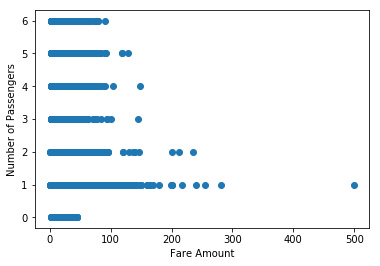

In [38]:

#plot for taxi fare price compared to rush hours/weekday 
%matplotlib inline 
plt.figure()
plt.scatter(taxi_feature['fare_amount'],taxi_feature['passenger_count'])
plt.xlabel("Fare Amount")
plt.ylabel("Number of Passengers")
plt.show()


We observe in the plot that the fare is highest for a single commuter. As the number of passengers increases in the cab, the fare goes down

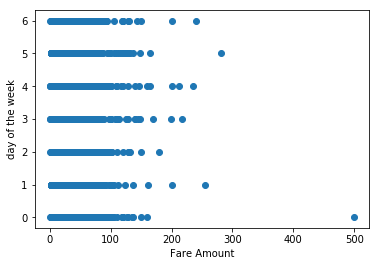

In [39]:
#plot for taxi fare price compared to day of the week 
plt.figure()
plt.scatter(taxi_feature['fare_amount'],taxi_feature['day_of_week'])
plt.ylabel("day of the week")
plt.xlabel("Fare Amount")
plt.show()

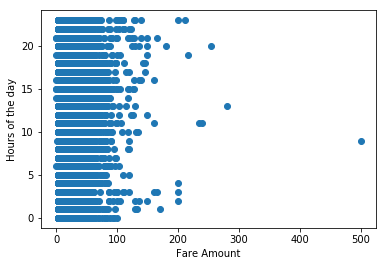

In [40]:
#plot for comparing hour of the day and fare amount
plt.figure()
plt.scatter(taxi_feature['fare_amount'],taxi_feature['hour'])
plt.ylabel("Hours of the day")
plt.xlabel("Fare Amount")
plt.show()

Use of haversine distance to calculate distance between 2 locations using latitude and longitude

Haversine
formula:
--- a = sin²(Δφ/2) + cos φ1 ⋅ cos φ2 ⋅ sin²(Δλ/2)
--- c = 2 ⋅ atan2( √a, √(1−a) )
--- d = R ⋅ c
where	φ is latitude, λ is longitude, R is earth’s radius (mean radius = 6,371km);
note that angles need to be in radians to pass to trig functions!

In [51]:
def haversine(df):
    R = 6371
    delta_lat = np.radians(df['dropoff_latitude'] - df['pickup_latitude'])
    delta_long = np.radians(df['dropoff_longitude'] - df['pickup_longitude'])
    lat2 = np.radians(df['dropoff_latitude'])
    lat1 = np.radians(df['pickup_latitude'])
    a = (np.sin(delta_lat/2.0)**2) + (np.sin(delta_long/2.0)**2) * np.cos(lat2) * np.cos(lat1)
    c = 2 * (np.arctan2(np.sqrt(a),np.sqrt(1 - a))) 
    df['distance'] = R * c
    return df

In [52]:
taxi_feature = haversine(taxi_feature)
#print(taxi_feature.head())
taxi_feature_test = haversine(taxi_feature_test)
#print(taxi_feature_test.head())

In [53]:
taxi_feature['dropoff_longitude'].replace(np.nan,0,inplace=True)
taxi_feature['dropoff_latitude'].replace(np.nan,0,inplace=True)
taxi_feature['distance'].replace(np.nan,0,inplace=True)
taxi_feature.dropna(axis=0,how='any')
print(taxi_feature.isnull().sum())
print("\n")
#test data
taxi_feature_test['dropoff_longitude'].replace(np.nan,0,inplace=True)
taxi_feature_test['dropoff_latitude'].replace(np.nan,0,inplace=True)
taxi_feature_test['distance'].replace(np.nan,0,inplace=True)
taxi_feature_test.dropna(axis=0,how='any')
print(taxi_feature_test.isnull().sum())

fare_amount          0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
year                 0
month                0
day                  0
hour                 0
day_of_week          0
distance             0
dtype: int64


key                  0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
year                 0
month                0
day                  0
hour                 0
day_of_week          0
distance             0
dtype: int64


In [54]:
#taxi_feature= taxi_feature.reset_index()
taxi_feature_x = taxi_feature.iloc[:,1:]
taxi_feature_y = taxi_feature.iloc[:,0:1]
print("y: \n" + str(taxi_feature_y.head()))
print("x: \n" + str(taxi_feature_x.head()))

y: 
                               fare_amount
key                                       
2009-06-15 17:26:21.0000001            4.5
2010-01-05 16:52:16.0000002           16.9
2011-08-18 00:35:00.00000049           5.7
2012-04-21 04:30:42.0000001            7.7
2010-03-09 07:51:00.000000135          5.3
x: 
                               pickup_longitude  pickup_latitude  \
key                                                                
2009-06-15 17:26:21.0000001          -73.844311        40.721319   
2010-01-05 16:52:16.0000002          -74.016048        40.711303   
2011-08-18 00:35:00.00000049         -73.982738        40.761270   
2012-04-21 04:30:42.0000001          -73.987130        40.733143   
2010-03-09 07:51:00.000000135        -73.968095        40.768008   

                               dropoff_longitude  dropoff_latitude  \
key                                                                  
2009-06-15 17:26:21.0000001           -73.841610         40.712278   
2010

In [59]:
#split dataset
x_train, x_test,y_train, y_test = \
    train_test_split(taxi_feature_x,taxi_feature_y,random_state=0,test_size=0.2)

#linear regression
lm_same = LinearRegression()
lm_model_same = lm_same.fit(x_train,y_train)
lm_y_same = lm_model_same.predict(x_test)
print("coefficient :" + str(lm_model_same.coef_))
print("MSE:\n" + str(mse(y_test,lm_y_same)))
print("R2_score" + str(r2_score(y_test,lm_y_same)))


coefficient :[[ 2.24019998e-03 -1.81140636e-04  4.03909787e-03  2.55584133e-03
   9.60289149e-02  6.39185204e-01  1.09491974e-01  3.14259891e-03
  -3.00362027e-02 -2.55251023e-03  6.39379073e-04]]
MSE:
92.10394169307858
R2_score0.01645734573494151


In [60]:
rf = RandomForestRegressor(random_state=30)
rf.fit(x_train, y_train)
rf_predict = rf.predict(x_test)
print("MSE:\n" + str(mse(y_test,rf_predict)))


C:\Users\Apurva Sinha\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


MSE:
22.327844191801706


In [66]:
#final prediction
#print(taxi_feature_test.head())

#print(taxi_feature_test.keys())
y_pred_final = rf.predict(taxi_feature_test.iloc[:,1:])

submission = pd.DataFrame(
    {'key': taxi_feature_test['key'],'fare_amount': y_pred_final},
    columns = ['key', 'fare_amount'])
#print(submission)
submission.to_csv('C:\Exercise\TaxiFare\submission.csv', index = False)

In [ ]:
#implement xgboost